Titanic

# Setup

## Import packages

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

from sklearn.model_selection import cross_val_score, ShuffleSplit

In [2]:
PROJECT_ROOT_DIR = '.'
TRAIN_PATH = PROJECT_ROOT_DIR + '/Dataset/train.csv'
IMAGES_PATH = PROJECT_ROOT_DIR + '/images'

# Get the Data

In [3]:
def load_train_data(train_path=TRAIN_PATH):
    csv_path = train_path
    return pd.read_csv(csv_path)

data = load_train_data()

# Take a Quick Look at the Data Structure

## An Overview of the Data

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Check the NULL values

In [38]:
info = data.isnull().sum()
info[info != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

These values must be filled with proper values latter on.

## Visualize the Data

By looking at the plot we find immediately that gender plays a decisive role.

### `Survived` - target

In [8]:
data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### `Pclass` and `Sex` and `Embarked` - picked

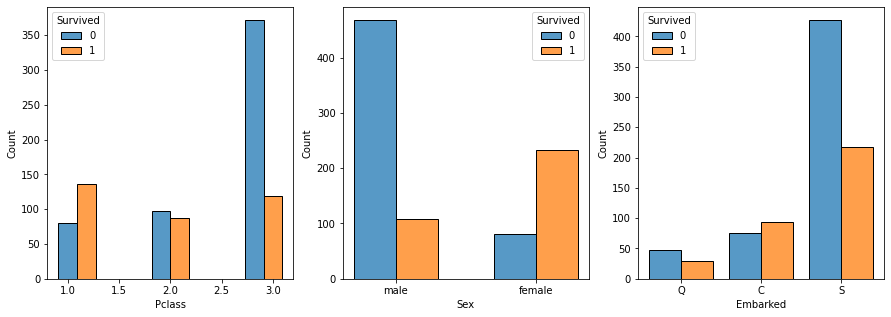

In [164]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(data=data, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(132)
sns.histplot(data=data, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(133)
sns.histplot(data=data, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)
plt.savefig(IMAGES_PATH+'/Pclass_Sex_Embarked.png')

plt.show()

### `Age` and `Fare` - picked

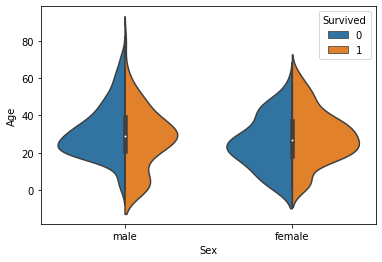

In [41]:
sns.violinplot(x ="Sex", y ="Age", hue ="Survived",data = data, split = True)
plt.show()

### `SibSp` and `Parch` - cut

In [14]:
data["SibSp_cut"] = pd.cut(data["SibSp"],
                           bins=[-0.1, 0.9, 1.9, np.inf], 
                           labels=[0, 1, 2])

data["Parch_cut"] = pd.cut(data["Parch"],
                           bins=[-0.1, 0.9, 1.9, np.inf], 
                           labels=[0, 1, 2])

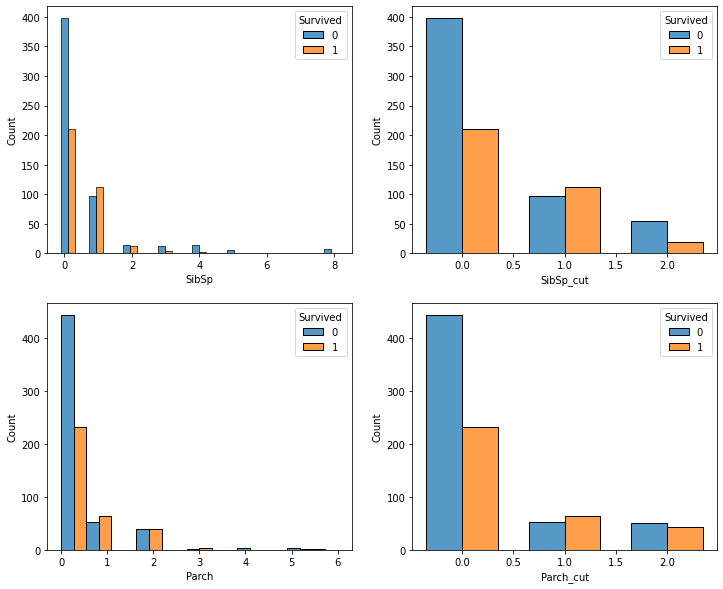

In [15]:
plt.figure(figsize=(12, 10))

plt.subplot(221)
sns.histplot(data=data, x="SibSp", hue="Survived", multiple="dodge", shrink=2)
plt.subplot(222)
sns.histplot(data=data, x="SibSp_cut", hue="Survived", multiple="dodge", shrink=0.7)

plt.subplot(223)
sns.histplot(data=data, x="Parch", hue="Survived", multiple="dodge")
plt.subplot(224)
sns.histplot(data=data, x="Parch_cut", hue="Survived", multiple="dodge", shrink=0.7)

plt.show()

# Prepare the Data

In [5]:
imputer = SimpleImputer(strategy="median")

data["Age_filled"] = imputer.fit_transform(data.Age.to_numpy().reshape(-1, 1))

In [6]:
data["SibSp_cut"] = pd.cut(data["SibSp"],
                           bins=[-0.1, 0.9, 1.9, np.inf], 
                           labels=[0, 1, 2])

data["Parch_cut"] = pd.cut(data["Parch"],
                           bins=[-0.1, 0.9, 1.9, np.inf], 
                           labels=[0, 1, 2])

In [7]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_filled',
       'SibSp_cut', 'Parch_cut'],
      dtype='object')

# Fill `Age` with mean value and use `StanderdScaler`

In [27]:
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
  ])

num_attribs = ["Age", "Fare"]
cat_attribs = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])


data = shuffle(data)
data.reset_index(inplace=True, drop=True)
X = full_pipeline.fit_transform(data)
y = data["Survived"].to_numpy()

## Logistic Regression (80.6%)

accuracy: 0.806


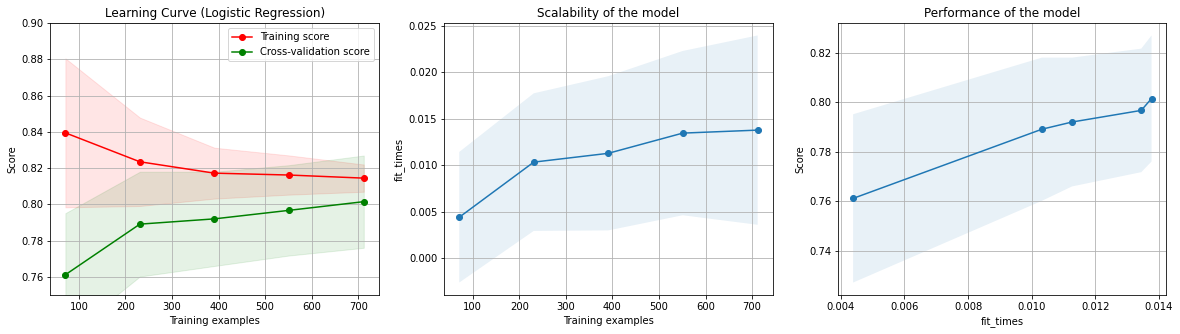

In [47]:
from sklearn.linear_model import LogisticRegression

title = "Learning Curve (Logistic Regression)"
clf = LogisticRegression(random_state=42)

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
utils.plot.plot_learning_curve(
    clf, title, X, y, ylim=(0.75, 0.9), cv=cv, n_jobs=4
)

score = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
print('accuracy: %.3f'%score.mean())
plt.show()

## Decision Tree (83.2%)

accuracy: 0.785


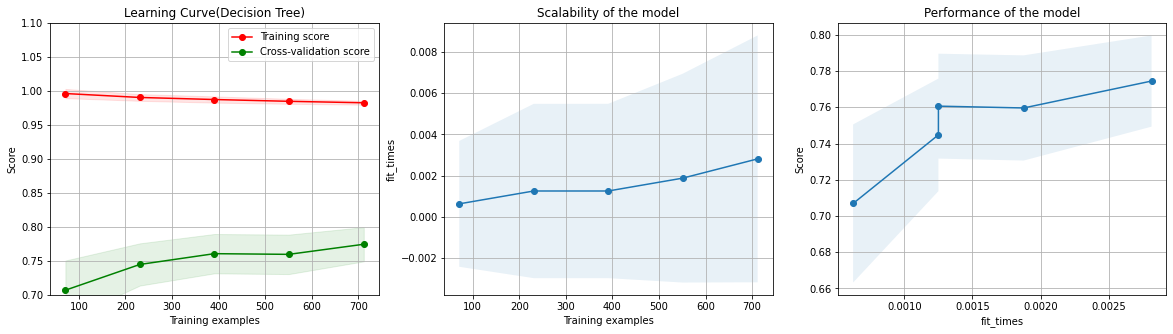

In [6]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()

title = "Learning Curve(Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
utils.plot.plot_learning_curve(
    tree_clf, title, X, y, ylim=(0.7, 1.1), cv=cv, n_jobs=4
)
score = cross_val_score(tree_clf, X, y, scoring='accuracy', cv=5)
print('accuracy: %.3f'%score.mean())
plt.show()

strongly over fitted!

### GridSearch

In [50]:
X.shape

(891, 25)

In [7]:
from sklearn.model_selection import GridSearchCV

grid = {
    "max_depth": list(range(5, 10)),
    "max_features": list(range(1, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(2, 25)),
    "criterion": ['gini', 'entropy'],
}

clf = tree.DecisionTreeClassifier()
search = GridSearchCV(
    estimator=clf, param_grid = grid,
    cv=5, verbose=2, n_jobs = 4
    )
search.fit(X, y)
print('best parameters: ', search.best_params_)

Fitting 5 folds for each of 5520 candidates, totalling 27600 fits
best parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 13, 'max_leaf_nodes': 23}


In [8]:
search.best_score_

0.831648986253217

## SVM (82.8%)

`scipy.stats.expon(scale)`=$pdf=scale\cdot e^{-scale\cdot x}$

In [36]:
import scipy
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
params = {
    'C': scipy.stats.expon(scale=100),
    'gamma': scipy.stats.expon(scale=.1),
    'kernel': ['rbf'],
}
clf = SVC()
search = RandomizedSearchCV(
    estimator=clf, param_distributions=params,
    n_iter=100, cv=5
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

best parameters:  {'C': 1.5813176556296222, 'gamma': 0.08589955934294802, 'kernel': 'rbf'}
best scores:  0.817048521750047


## Random Forest (83.7%)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    "max_depth": list(range(6, 12)),
    "max_features": list(range(5, 25)), # range \in (0, n_features]
    "max_leaf_nodes": list(range(10, 35)),
}

clf = RandomForestClassifier()
search = RandomizedSearchCV(
    estimator=clf, param_distributions=params,
    n_iter=50, cv=5, n_jobs=4, verbose=1,
)
search.fit(X, y)
print('best parameters: ', search.best_params_)
print('best scores: ', search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'n_estimators': 400, 'max_leaf_nodes': 29, 'max_features': 23, 'max_depth': 8}
best scores:  0.8373046262004896


## Error analysis

In [ ]:
from sklearn.model_selection import cross_val_predict

In [35]:
params = {'criterion': 'gini', 'max_depth': 7, 'max_features': 13, 'max_leaf_nodes': 23}
best_tree_clf = tree.DecisionTreeClassifier(**params)
y_pred = cross_val_predict(best_tree_clf, X, y, cv=5)

errors_tree = data[y_pred != y]
errors_tree

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
9,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
17,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
861,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


In [37]:
params = {'C': 1.5813176556296222, 'gamma': 0.08589955934294802, 'kernel': 'rbf'}
best_SVM_clf = SVC(**params)
y_pred = cross_val_predict(best_SVM_clf, X, y, cv=5)

errors_SVM = data[y_pred != y]
errors_SVM

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,363,0,3,"Barbara, Mrs. (Catherine David)",female,45.0,0,1,2691,14.4542,NaN,C
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
17,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


In [38]:
params = {'n_estimators': 400, 'max_leaf_nodes': 29, 'max_features': 23, 'max_depth': 8}
best_rndf_clf = RandomForestClassifier(**params)
y_pred = cross_val_predict(best_rndf_clf, X, y, cv=5)

errors_rndf = data[y_pred != y]
errors_rndf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
21,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
46,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
56,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
864,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S
874,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
876,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
884,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


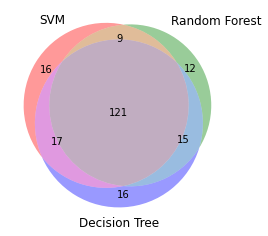

In [166]:
from matplotlib_venn import venn3

set1 = set(errors_SVM.index)
set2 = set(errors_rndf.index)
set3 = set(errors_tree.index)

venn3([set1, set2, set3], ('SVM', 'Random Forest', 'Decision Tree'))
plt.savefig(IMAGES_PATH+'/error_venn_plot.png')
plt.show()

All three classifiers make common mistakes at same instances, let's explore these instances.

In [82]:
def find_common_errors(errors):
    """
    Parameters
    ----------
    errors: a list of Dataframes containing mistaken instance
    Returns: Dataframe of common errors
    -------
    """
    list_idx = [np.array(i.index) for i in errors]
    idx = list_idx[0]
    # list(set(list1).intersection(list2))
    for i in list_idx:
        idx = list(set(i).intersection(idx))

    return idx

errors = [errors_tree, errors_SVM, errors_rndf]
common_idx = find_common_errors(errors)
common_errors = errors_tree.loc[common_idx]
common_errors

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
512,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
4,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
516,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S
519,703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C
15,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
458,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,S
470,126,1,3,"Nicola-Yarred, Master. Elias",male,12.0,1,0,2651,11.2417,NaN,C
488,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
493,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S


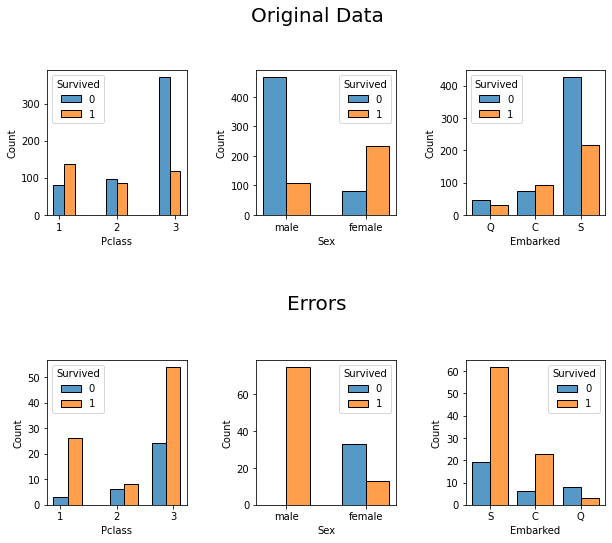

In [168]:
fig = plt.figure(figsize=(10, 8))

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Original Data', fontsize=20)
subfigs[0].subplots(nrows=1, ncols=3, sharey=True, sharex=True)
plt.subplot(231)
sns.histplot(data=data, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(232)
sns.histplot(data=data, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(233)
sns.histplot(data=data, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)

subfigs[1].suptitle('Errors', fontsize=20)
plt.subplot(234)
sns.histplot(data=common_errors, x="Pclass", hue="Survived", multiple="dodge", shrink=2.0)
plt.subplot(235)
sns.histplot(data=common_errors, x="Sex", hue="Survived", multiple="dodge", shrink=.6)
plt.subplot(236)
sns.histplot(data=common_errors, x="Embarked", hue="Survived", multiple="dodge", shrink=.8)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)
plt.savefig(IMAGES_PATH+'/two_distributions.png')
plt.show()